# VaR and Monte Carlo Simulations

## Importing all required libraries

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as web
from matplotlib.ticker import FuncFormatter

## Installing the Portfolio Optimzation Library

In [50]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from matplotlib.ticker import FuncFormatter

## Selection of Stocks and Timeframe

In [51]:
tickers = ['GOOGL', 'META', 'AAPL', 'NFLX', 'AMZN']
thelen = len(tickers)
price_data = []
for ticker in range(thelen):
    prices = web.DataReader(tickers[ticker], start='2018-06-20', end='2020-06-20', data_source='yahoo')
    
    price_data.append(prices[['Adj Close']])

df_stocks = pd.concat(price_data, axis=1)
df_stocks.columns=tickers
df_stocks.tail()

,GOOGL,META,AAPL,NFLX,AMZN
Date,,,,,
2020-06-15,71.037003,232.500000,84.432198,425.500000,128.634003
2020-06-16,72.323502,235.649994,86.669853,436.130005,130.763504
2020-06-17,72.626999,235.529999,86.549225,447.769989,132.048996
2020-06-18,71.706001,235.940002,86.583694,449.869995,132.699005
2020-06-19,71.232002,238.789993,86.088905,453.720001,133.750504


## Annualized return

In [52]:
mu = expected_returns.mean_historical_return(df_stocks)

## Sample Variance of Portfolio

In [53]:
sigma = risk_models.sample_cov(df_stocks)

## Max Sharpe Ratio - Tangent to the EF

In [54]:
from pypfopt import objective_functions, base_optimizer
ef = EfficientFrontier(mu, sigma, weight_bounds=(0,1)) #weight bounds in negative allows shorting of stocks
sharpe_pfolio = ef.max_sharpe()

## May Use Add Objective to Ensure Minimum Zero Weighting to Individual Stocks

In [55]:
sharpe_pwt = ef.clean_weights()
print(sharpe_pwt)

OrderedDict([('GOOGL', 0.0), ('META', 0.0), ('AAPL', 1.0), ('NFLX', 0.0), ('AMZN', 0.0)])


## VaR Calculation

In [56]:
ticker_rx2 = []

## Convert Dictionary to list of asset weights from Max Sharpe Ratio Portfolio

In [57]:
sh_wt = list(sharpe_pwt.values())
sh_wt = np.array(sh_wt)

## Convert Stocks Prices to Cumulative Return/HPR

In [58]:
for a in range(thelen):
    ticker_rx = df_stocks[[tickers[a]]].pct_change()
    ticker_rx = (ticker_rx+1).cumprod()
    ticker_rx2.append(ticker_rx[[tickers[a]]])

ticker_final = pd.concat(ticker_rx2, axis=1)
ticker_final

,GOOGL,META,AAPL,NFLX,AMZN
Date,,,,,
2018-06-19,NaN,NaN,NaN,NaN,NaN
2018-06-20,1.004564,1.022837,1.004362,1.029088,1.008820
2018-06-21,0.992152,1.020305,0.998761,1.025828,0.997371
2018-06-22,0.992025,1.021520,0.995853,1.015087,0.988984
2018-06-25,0.966565,0.994228,0.981044,0.949380,0.958709
...,...,...,...,...,...
2020-06-15,1.205355,1.177275,1.897607,1.050669,1.483001
2020-06-16,1.227184,1.193225,1.947898,1.076917,1.507551
2020-06-17,1.232334,1.192617,1.945187,1.105659,1.522372


## Plot Graph of Cumulative/HPR of all stocks

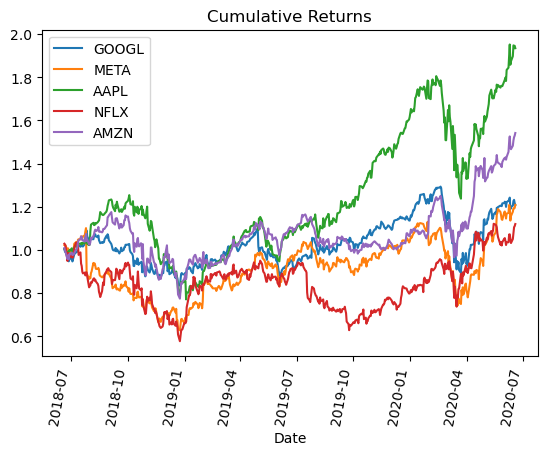

In [59]:
for i, col in enumerate(ticker_final.columns):
    ticker_final[col].plot()

plt.title('Cumulative Returns')
plt.xticks(rotation=80)
plt.legend(ticker_final.columns)

## Taking Latest Values of Return

In [60]:
pret = []
prel = []
price = []

for x in range(thelen):
    pret.append(ticker_final.iloc[[-1],[x]])
    price.append((df_stocks.iloc[[-1], [x]]))

prel = pd.concat(pret, axis=1)
prel = np.array(prel)
price = pd.concat(price, axis=1)
varsigma = prel.std()
ex_rtn = prel.dot(sh_wt)

print('The weighted expected portfolio return for selected time period is '+ str(ex_rtn))

#ex_rtn = (ex_rtn)**0.5-(1) #Annualizing the cumulative return (will not affect outcome)

price = price.dot(sh_wt) #Calculating weighted value
print(ex_rtn, varsigma, price)

The weighted expected portfolio return for selected time period is [1.93484138]
[1.93484138] 0.30246234040002506 Date
2020-06-19    86.088905
dtype: float64


## Setting up and running Monte Carlo Simulation

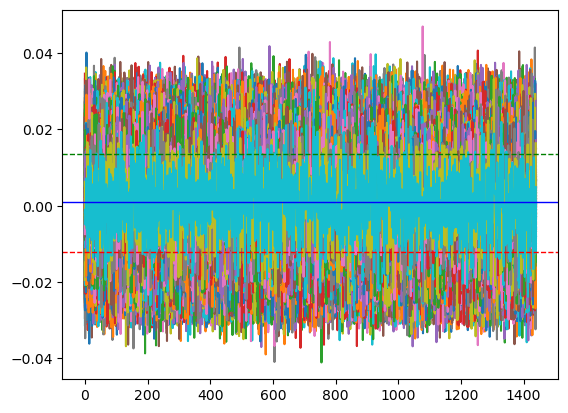

In [61]:
from scipy.stats import norm
import math

time = 1440 #No. of days (steps or trading days in this case)
lt_price = []
final_res = []

for i in range (10000): #10000 runs of simulation
    daily_returns = (np.random.normal(ex_rtn/time, varsigma/math.sqrt(time), time))
    plt.plot(daily_returns)

plt.axhline(np.percentile(daily_returns,5), color='r', linestyle='dashed', linewidth=1)
plt.axhline(np.percentile(daily_returns,95), color='g', linestyle='dashed', linewidth=1)
plt.axhline(np.mean(daily_returns), color='b', linestyle='solid', linewidth=1)

plt.show()

## Visualizing the distribution plot of the returns

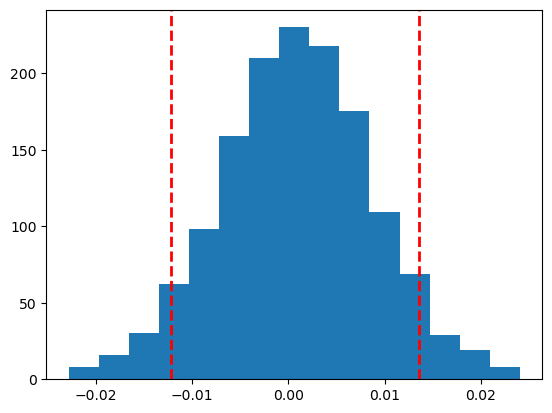

In [62]:
plt.hist(daily_returns, bins=15)
plt.axvline(np.percentile(daily_returns,5), color='r', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(daily_returns,95), color='r', linestyle='dashed', linewidth=2)

plt.show()

## Printing exact upper and lower limit values

In [63]:
print(np.percentile(daily_returns,5), np.percentile(daily_returns,95))
#VaR - Minimum loss of 5.7% at a 5% probability, also a gain can be higher than 15% with a 5% probability

pvalue = 1000 #Portfolio Value

print('$Amount required to cover minimum losses for one day is ' + str(pvalue* - np.percentile(daily_returns,5)))

-0.012208453176140388 0.013602393449714874
$Amount required to cover minimum losses for one day is 12.208453176140388
